# <font color=blue> The Titanic Project</font>

It is probably not the best job to decide who will live and who will die, but let's at least honor the passenger on the Titanic with this humble model that given the list of passengers on board and their info is capable of predicting who will die on the Titanic and who will have the privilage to be saved. 
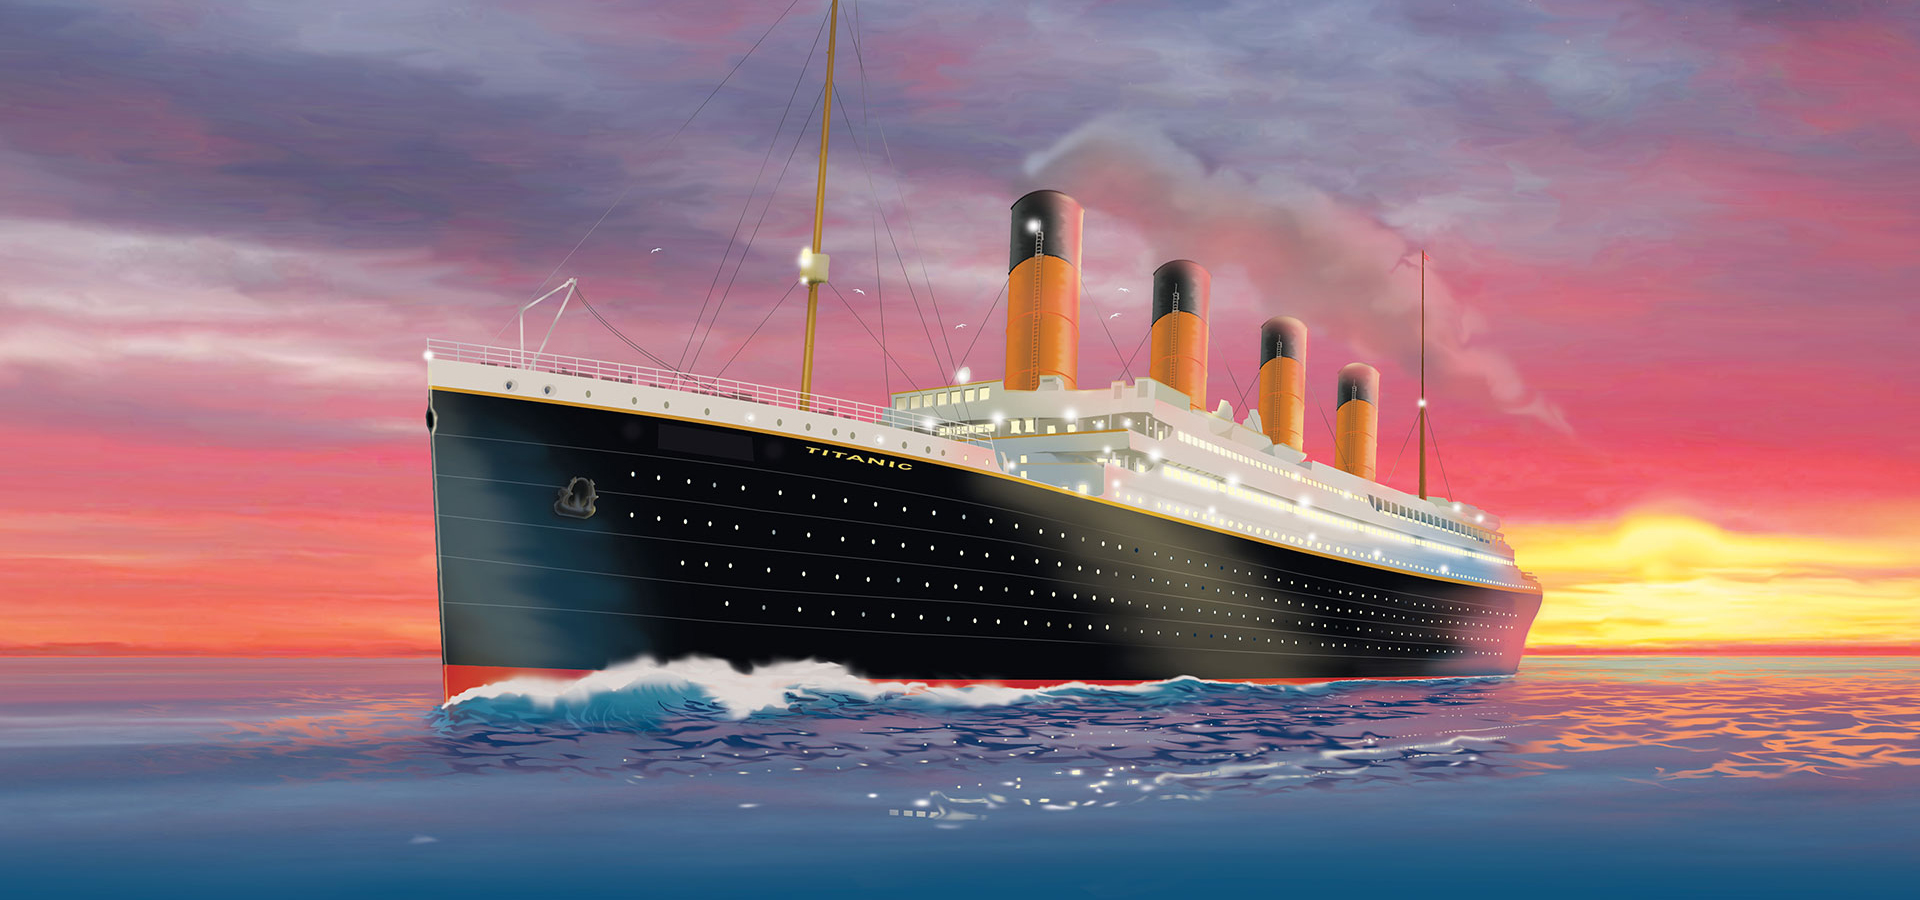

## Importing the libraries

As always, we'll start with importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from fancyimpute import MICE
import random

%matplotlib inline

In [ ]:
def extract_numerical_features(df):
        df = df.copy()
        # Identify numerical columns which are of type object
        numerical_features = pd.Series(data=False, index=df.columns, dtype=bool)

        for feature in df.columns:
            if any(tuple(df[feature].apply(lambda x: type(x)) == int)) or \
                            any(tuple(df[feature].apply(lambda x: type(x)) == float)) & \
                            (not any(tuple(df[feature].apply(lambda x: type(x)) == str))):
                numerical_features[feature] = 1
        return numerical_features[numerical_features == 1].index

In [ ]:
def estimate_by_mice(df):
        df_estimated_var = df.copy()
        random.seed(129)
        mice = MICE()  # model=RandomForestClassifier(n_estimators=100))
        res = mice.complete(np.asarray(df.values, dtype=float))
        df_estimated_var.loc[:, df.columns] = res[:][:]
        return df_estimated_var

In [ ]:
from sklearn.preprocessing import LabelEncoder

#Auto encodes any dataframe column of type category or object.
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df

## Getting the data

In [ ]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_train_raw = df_train.copy()  # Generate a copy of thr original data, will be handy when trying different data cleaning methods
df_test_raw = df_test.copy()
df_train.head() # Shows the first 5 lines of the dataframe

Let's see also how the test data looks like:

In [ ]:
df_test.head()

## Getting familiar with the data
As can be seen, our data has 12 features (columns) where one of them is actually the target ('Survived') so practically we have 11 features.
Let's get some intuition by using the method 'describe(). Pay attention that this will work only with the numerical features in our data.

In [ ]:
df_train.describe()

## Intuitoin regarding the numerical data
1. "Count" - The most interesting thing is the fact that there is quite a bit of missing data on the "Age" column, we will check that in a minute.
2. "mean/std" - used to understand how the different variables are distributed - low std implies that the data is closely ditributed around the mean value.
3. "min/max" - Some interesting things can be seen by looking on the table above: 
    - There are people with 'Fare' 0.0 (maybe the boat staff?) we might want to track these people later on. 
    - We can also see that there are children on board as young as 4 months and also elders at the age of 80, would be interesting to follow these two age groups as we go by. 
    - We can also see that the max 'Fare' is far above the mean - this means that there is at least on passenger that paid loads of money to get on board.
    - We can also see that there are passengers with no family on board and on the other hand quite big families of 6-8 members


## Missin Data
One of the most important data preperation tasks is the handling of the missing data. It is obviously important to first check the extent of missing data in your data and then decide how to handle it. The decision how to handle the missing data varies from case to case and there is probably no obvious method that will always fit any case. The most easy method of dealing with missing data is just to remove it altogether - practically - remove any row that has missing cells. This method has many disadvantages as it might remove valuble data from your dataset, create bias, reduce variance and more. As a rule of thumb - You should probably **consider** removing the missing data rows if their quantity is less 5% of the entire dataset.

Let's get some intuition about the missing data in our data set using the excellent library 'missingno' (https://github.com/ResidentMario/missingno)


In [ ]:
msno.matrix(df_train, figsize=(20,10))

* As we can see in the matrix plot above - there are only 3 features with missing data - 'Age', 'Cabin' and 'Embarked. It seems that for 'Embarked' only few data points are missing while in the case of 'Cabin' the majority is missing (missing = white color). In the case of 'Age' - it seems that the majority of data exists but quite large quantity of it is missing.
* Let's try to put some numbers on this "high level" info using a bar plot:

In [ ]:
msno.bar(df_train, color="green", figsize=(20,5))

Ok, so now things are clearer. We can see that on the 'Age' column we have only 714 data points - this means that we have 19.8% missing data (177 out of 891). on the 'Cabin' column we have 77% missing data !! this is a huge number. in such a case we should probably remove this feature as it will be almost impossible to try and complete these values in a wise way. on the 'Embarked' column we have only 0.2% missing data (2 data points out of 891) - as the precentage is very small here, the most easy thing to do will be to remove these rows.

In [ ]:
msno.heatmap(df_train, figsize=(5,5))

As can be seen, there is no clear correlations between the missing data points / features.

Let's also check the test data using the same method:

In [ ]:
msno.matrix(df_test, figsize=(20,10))

In [ ]:
msno.bar(df_test, color="green", figsize=(20,5))

As we can see, the test data also include missing data - 20% missing 'Age' and 78% missing 'Cabin'. We can also see a single 'Fare' data point which is missing

Let's start by removing the 'Cabin' column altogether:

In [ ]:
df_train = df_train.drop(['Cabin'], axis = 1)
df_test = df_test.drop(['Cabin'], axis = 1)

In [ ]:
df_train_numerical = extract_numerical_features(df_train)
df_test_numerical = extract_numerical_features(df_test)
df_train.loc[:, tuple(df_train_numerical)] = estimate_by_mice(df_train[df_train_numerical])
df_test.loc[:, tuple(df_test_numerical)] = estimate_by_mice(df_test[df_test_numerical])

In [ ]:
msno.matrix(df_train, figsize=(20,10))

In [ ]:
df_train.describe()

In [ ]:
msno.matrix(df_test, figsize=(20,10))

Now let's delete the two rows with the missing 'Embarked' data in the training set:

In [ ]:
df_train = df_train.dropna(subset=['Embarked'])

In [ ]:
df_train.describe()

In [ ]:
df_train.head()

In [ ]:
df_train.describe(include=['O'])

## Intuitoin regarding the categorical data
1. There are 64.7% males (top = 'male', freq = 577 => male_freq = 577/891 = 64.7%)
2. High rate of dulicants on the ticket number column - 23% ((891 - 681) / 891)
3. Majority of passengers embarked on station 'S' - 72% (top = 'S', freq = 644)

## Look into the correlation between certain features and the target
The goal is basically to understand how the features correlates with the fact that the passenger survived or not.

In the overview for this project it was claimed that 3 populations have been survived more than others:
 1. females (Sex = female)
 2. children (Age < ?)
 3. passengers with high socio-economic status (pclass = 1)

Let's put those assumptions into test:

In [ ]:
print(df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False), '\n----------')
print(df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False), '\n----------')

As can be seen - there is indeed correlation between the Sex/gender of the pasenger and his survival. It is very obvious to see that females have much higher survival rate (74%) compared to males - confirming assumption #1 above.
We can also see that the highest survival rate belongs to passengers with high socio-economic status (pclass = 1) - 63% have been survived compared to 47% in pclass2 and 24% in pclass3 - confirming assumption #3 above.

Conclusion - 'Sex' and 'Pclass' should be included in our model

In order to test assumption #2 above, it will be easier to show it on a plot as the 'Age' columns includes many uniqe values so it will not be convinient to show it using a list as we did with 'Sex' and 'Pclass'

In [ ]:
sns.set(font_scale = 1.4)
g = sns.FacetGrid(df_train, col='Survived', size=4, aspect=1.6)
g.map(plt.hist, 'Age', alpha=.6, bins=80, color="g")

As we can see based on the plots above:
    1. Children under the age of 5 has hige survival rate (confirming assumption #2 above)
    2. Elders above the age of 75 have high survival rate
    3. Majority of the people in the age 15-32 have not survived
    4. Majority of the people are in the age 15-35
    
Conclusion - 'Age' should be included in our model, however, we need to consider defining age ranges as it seems that for some ranges the correlation is strong (children, elders) while for other ranges there is no obvious correlation

In [ ]:
df_train['AgeRange'] = pd.cut(df_train['Age'], 20)
print(df_train[['AgeRange', 'Survived']].groupby(['AgeRange'], as_index=False).mean().sort_values(by='Survived', ascending=False), '\n----------')
#print(list(df_train.columns.values))

Conclusion - we will use age ranges as a feature in our model. 

Le's check some more correlations:

In [ ]:
print(df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False), '\n----------')
print(df_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False), '\n----------')
print(df_train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False), '\n----------')

Based on the info above, we can see the following:
 1. 'Embarked': Majority of people embarked at port 'C' have survived (55%) compared to ports 'E' and 'S' where the majority of people didn't survive.
 2. 'SibSp' and 'Parch': no clear correlation at this point, let's try to generate a new feature called "FamilySize":

In [ ]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch']
print(df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False), '\n----------')

based on the info above we can see that passengers with 3/2/1 family members had high survival rate while larger families (>3) had low survival rate. We can also see that passenger who were alone (FamilySize = 0) had low survival rate.

Lets now check one of the other points we made as part of our anaysis  of the numerical data above. 
1. "There are people with 'Fare' 0.0 (maybe the boat staff?) we might want to track these people later on"

In [ ]:
fare_zero = df_train[df_train['Fare'] == 0]
fare_zero.describe()

As can be seen - only 6% from the passengers who paid a fare of 0.0 survived (1 passenger out of the 15 passengers). Let's try to divide the fares to ranges and check their correlation with the survival rate 

In [ ]:
df_train['FareRange'] = pd.cut(df_train['Fare'], 5)
print(df_train[['FareRange', 'Survived']].groupby(['FareRange'], as_index=False).mean().sort_values(by='Survived', ascending=False), '\n----------')

In [ ]:
bins = [0,102,204,307,409,512]
labels=[0,1,2,3,4]
df_train['Fare'] = pd.cut(df_train['Fare'], bins=bins, labels=labels, include_lowest=True)
df_test['Fare'] = pd.cut(df_test['Fare'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
df_train.head()

In [ ]:
df_test.head()

Let's now drop 'SibSp' and 'Parch'

In [ ]:
df_train = df_train.drop(['SibSp', 'Parch'], axis=1)
df_test = df_test.drop(['SibSp', 'Parch'], axis=1)

In [ ]:
df_TrTe = [df_train, df_test]
df_train.head()
#df_test.head()

Let's also drop the 'PassengerId', 'Name', 'Ticket' and 'FareRange':

In [ ]:
df_train = df_train.drop(['PassengerId', 'Name', 'Ticket', 'FareRange'], axis=1)
df_test = df_test.drop(['Name', 'Ticket'], axis=1)
df_TrTe = [df_train, df_test]
df_train.head()

We will now encode the Age into ranges of 4 years each:

In [ ]:
bins = [*range(0,84,4)]
labels=[*range(20)]
df_train['Age'] = pd.cut(df_train['Age'], bins=bins, labels=labels, include_lowest=True)
df_test['Age'] = pd.cut(df_test['Age'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
df_TrTe = [df_train, df_test]
df_train.head()

Let's now drop the 'AgeRange' column:

In [ ]:
df_train = df_train.drop(['AgeRange'], axis=1)
df_TrTe = [df_train, df_test]
df_train.head()
df_test.head()

In [ ]:
df_test.info()

In [ ]:
df_train = dummyEncode(df_train)
df_test = dummyEncode(df_test)

In [ ]:
X_train = df_train.drop("Survived", axis=1)
Y_train = df_train["Survived"]
X_test  = df_test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


In [ ]:

# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

In [ ]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

In [ ]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

In [ ]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

In [ ]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes',
              'Stochastic Gradient Decent',  
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_sgd, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

In [ ]:
df_test = df_test.astype(int)
df_test["PassengerId"] = df_test["PassengerId"].astype(str)

df_test.head()

In [ ]:
Y_pred = Y_pred.astype(int)

In [ ]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": Y_pred
    })
#submission.to_csv('submission.csv', index=False)